In [118]:
import os
import sys
sys.path.append('/'.join(os.getcwd().split('/')[:-1]))

import numpy as np
import matplotlib.pyplot as plt
import matplotlib

from Agents import QLearningAgent, BayesianQAgent, PSRLAgent, MomentMatchingAgent, UbeNoUnrollAgent
from Environments import PriorMDP
from utils import solve_tabular_continuing_PI, run_experiment, run_oracle_experiment, load_agent

from tqdm import tqdm_notebook as tqdm

# For saving figures and agents
if not os.path.exists('results'): os.mkdir('results')
if not os.path.exists('results/figures'): os.mkdir('results/figures')
if not os.path.exists('results/agent_logs'): os.mkdir('results/agent_logs')

fig_loc = 'results/figures/'

plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rc('legend', fontsize=16)
plt.rc('figure', titlesize=50)

# Environment constants

In [119]:
# PriorMDP constants
num_time_steps = 5000
save_every = num_time_steps // 100

Ns = 4
Na = 2

env_params = {'Ns'         : 4,
              'Na'         : 2,
              'kappa'      : 1.0,
              'mu0'        : 0.0,
              'lamda'      : 1.0,
              'alpha'      : 4.0,
              'beta'       : 4.0,
              'seed'       : 1}

# Define environment
environment = PriorMDP(env_params)

# Number of PI steps and maximum buffer length (PSRL, UBE and MM only)
max_iter = 2 * Ns
max_buffer_length = Ns + 1

# Q-Learning

In [120]:
# Agent parameters
agent_params = {'gamma'            : 0.9,
                'dither_mode'      : 'epsilon-greedy',
                'dither_param'     : 0.2,
                'lr'               : 0.1,
                'Q0'               : 0.0,
                'anneal_timescale' : float('inf'),
                'sa_list'          : environment.sa_list()}

In [121]:
# for seed in tqdm(range(10)):

#     # Define agent
#     agent = QLearningAgent(agent_params)

#     # Run experiment
#     run_experiment(environment=environment,
#                    agent=agent,
#                    seed=seed,
#                    num_time_steps=num_time_steps,
#                    max_buffer_length=1,
#                    save_every=save_every)

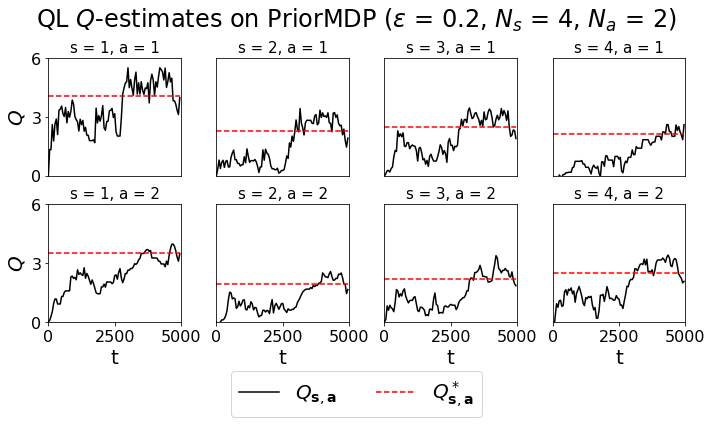

In [84]:
P, R = environment.get_mean_P_and_R()
pi, Q = solve_tabular_continuing_PI(P, R, gamma=0.9, max_iter=max_iter)

agent = load_agent(environment, QLearningAgent(agent_params), seed=0)

means = []
for t in np.arange(num_time_steps // save_every):

    means.append([])
    for s in range(Ns):
        
        means[-1].append([])
        for a in range(Na):
            
            means[-1][-1].append(agent.Qlog[t][s][a])
            
means = np.array(means)

fig = plt.figure(figsize=(10, 6))

leg_names = ['$Q_{\mathbf{s}, \mathbf{a}}$', '$Q^*_{\mathbf{s}, \mathbf{a}}$']
leg = [None] * 2

for s in range(Ns):
    for a in range(Na):
        
        plt.subplot(Na, Ns, s + Ns * a + 1)
        leg[0], = plt.plot(np.arange(len(means[:, s, a])) * save_every, means[:, s, a], color='black')
        
        leg[1], = plt.plot(np.arange(len(means[:, s, a])) * save_every, 
                          np.ones(len(means[:, s, a])) * Q[s, a], 
                          '--',
                          color='red')
        plt.ylim([0, 6])
        plt.yticks([0, 3, 6])
        plt.xticks([0, num_time_steps // 2, num_time_steps])
        plt.xlim([0, num_time_steps])
        plt.tight_layout()
        
        if s > 0:
            plt.yticks([])
        else:
            plt.ylabel('$Q$', fontsize=20)
        if a == 0:
            plt.xticks([])
        else:
            plt.xlabel('t', fontsize=20)
        
        plt.title(r's = {}, a = {}'.format(s + 1, a + 1), fontsize=15)
            
title = 'QL $Q$-estimates on PriorMDP ($\epsilon$ = {}, $N_s$ = {}, $N_a$ = {})'
fig.suptitle(title.format(agent.dither_param, Ns, Na), fontsize=24)
plt.figlegend(leg, leg_names, loc = 'lower center', ncol=2, labelspacing=0., fontsize=20)
plt.tight_layout(w_pad=1)
fig.subplots_adjust(top=0.86, bottom=0.25)

save_name = 'ql-{}-qestimates-priormdp-{}-{}'.format(agent.dither_param, Ns, Na).replace('.', '_')
plt.savefig(fig_loc + save_name + '.pdf', bbox_inches='tight')
plt.show()

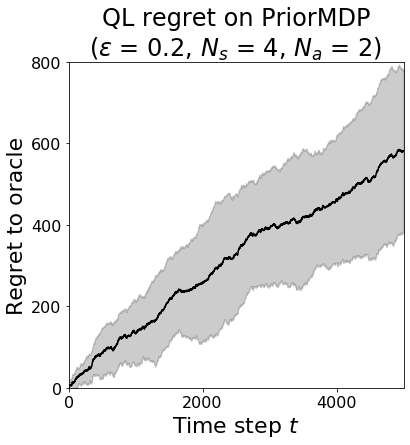

In [85]:
agent_rs, oracle_rs = [], []

for seed in range(10):
    
    # Define agent
    agent = load_agent(environment, QLearningAgent(agent_params), seed=seed)
    
    agent_rs.append(agent.train_r)

    oracle_r = run_oracle_experiment(environment=environment,
                                     seed=seed,
                                     gamma=0.9,
                                     num_time_steps=num_time_steps,
                                     num_PI_iter=max_iter)[2]
    
    oracle_rs.append(oracle_r)
    
agent_rs, oracle_rs = np.array(agent_rs), np.array(oracle_rs)

regrets = np.cumsum(oracle_rs - agent_rs, axis=-1)
means = np.mean(regrets, axis=0)
stds = np.var(regrets, axis=0)**0.5

plt.figure(figsize=(6, 6))
plt.plot(means, color='k')
plt.fill_between(np.arange(len(means)), means - stds, means + stds, color='k', alpha=0.2)
plt.locator_params(axis='y', nbins=4)
plt.locator_params(axis='x', nbins=4)
plt.title('QL regret on PriorMDP\n($\epsilon$ = {}, $N_s$ = {}, $N_a$ = {})'.format(agent.dither_param, Ns, Na),
          fontsize=24)
plt.xlabel('Time step $t$', fontsize=22)
plt.ylabel('Regret to oracle', fontsize=22)
plt.xlim([0, num_time_steps])
plt.ylim([0, 800])

save_name = 'ql-{}-regret-priormdp-{}-{}'.format(agent.dither_param, Ns, Na).replace('.', '_')
plt.savefig(fig_loc + save_name + '.pdf', bbox_inches='tight')
plt.show()

# Bayesian Q-Learning

In [124]:
# Agent parameters
agent_params = {'gamma'               : 0.9,
                'mu0'                 : 0.0,
                'lamda'               : 4.0,
                'alpha'               : 3.0,
                'beta'                : 3.0,
                'num_mixture_samples' : 1000,
                'sa_list'             : environment.sa_list()}

In [125]:
for seed in tqdm(range(10)):

    # Define agent
    agent =  BayesianQAgent(agent_params)

    # Run experiment
    run_experiment(environment=environment,
                   agent=agent,
                   seed=seed,
                   num_time_steps=num_time_steps,
                   max_buffer_length=1,
                   save_every=save_every)

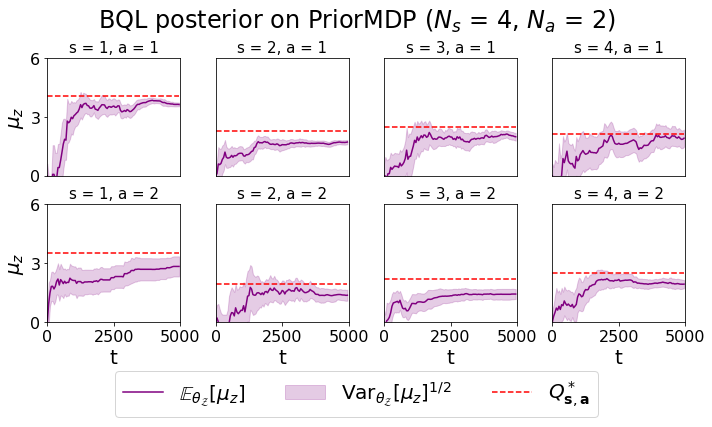

In [126]:
P, R = environment.get_mean_P_and_R()
pi, Q = solve_tabular_continuing_PI(P, R, gamma=0.9, max_iter=max_iter)

agent = load_agent(environment, BayesianQAgent(agent_params), seed=2)

means, stds = [], []
for t in np.arange(num_time_steps // save_every):
    
    means.append([])
    stds.append([])
    
    for s in range(Ns):
        
        means[-1].append([])
        stds[-1].append([])
        
        for a in range(Na):
            mu, lamda, alpha, beta = agent.Qpost_log[t][s][a]
            var = beta / (lamda * (alpha - 1))
            
            means[-1][-1].append(mu)
            stds[-1][-1].append(var**0.5)
            
means, stds = np.array(means), np.array(stds)

fig = plt.figure(figsize=(10, 6))

actions = ['left', 'right']
leg_names = ['$\mathbb{E}_{\\theta_{\mathcal{Z}}}[\mu_z]$',
             'Var$_{\\theta_{\mathcal{Z}}}[\mu_z]^{1/2}$',
             '$Q^*_{\mathbf{s}, \mathbf{a}}$']
leg = [None] * 3

color = 'purple'

for s in range(Ns):
    for a in range(Na):
        
        plt.subplot(Na, Ns, s + 4 * a + 1)
        leg[0], = plt.plot(np.arange(len(means[:, s, a])) * save_every, means[:, s, a], color='purple')
        leg[1] = plt.fill_between(np.arange(len(means[:, s, a])) * save_every, 
                                   means[:, s, a] + stds[:, s, a],
                                   means[:, s, a] - stds[:, s, a],
                                   color='purple', alpha=0.2)
        
        leg[2], = plt.plot(np.arange(len(means[:, s, a])) * save_every,
                          np.ones(len(means[:, s, a])) * Q[s, a], 
                          '--',
                          color='red')
        plt.ylim([0, 6])
        plt.yticks([0, 3, 6])
        plt.xticks([0, num_time_steps // 2, num_time_steps])
        plt.xlim([0, num_time_steps])
        plt.tight_layout()
        
        if s > 0:
            plt.yticks([])
        else:
            plt.ylabel('$\mu_z$', fontsize=20)
        if a == 0:
            plt.xticks([])
        else:
            plt.xlabel('t', fontsize=20)
        
        plt.title(r's = {}, a = {}'.format(s + 1, a + 1), fontsize=15)
            
fig.suptitle('BQL posterior on PriorMDP ($N_s$ = {}, $N_a$ = {})'.format(Ns, Na), fontsize=24)
plt.figlegend(leg, leg_names, loc = 'lower center', ncol=3, labelspacing=0., fontsize=20)
plt.tight_layout(w_pad=1)
fig.subplots_adjust(top=0.86, bottom=0.25)

mu0, lamda, alpha, beta = agent.mu0, agent.lamda, agent.alpha, agent.beta
save_name = 'bql-{}-{}-{}-{}-posterior-priormdp-{}-{}'.format(mu0, lamda, alpha, beta, Ns, Na).replace('.', '_')
plt.savefig(fig_loc + save_name + '.pdf', bbox_inches='tight')
plt.show()

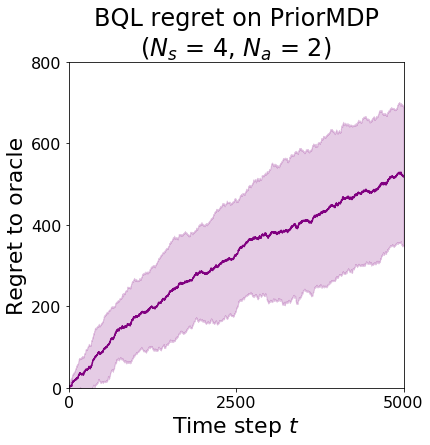

In [127]:
color = 'purple'

agent_rs, oracle_rs = [], []
for seed in range(10):
    
    # Define agent
    agent = load_agent(environment, BayesianQAgent(agent_params), seed=seed)
    
    agent_rs.append(agent.train_r)

    oracle_r = run_oracle_experiment(environment=environment,
                                     seed=seed,
                                     gamma=0.9,
                                     num_time_steps=num_time_steps,
                                     num_PI_iter=max_iter)[2]
    
    oracle_rs.append(oracle_r)
    
agent_rs, oracle_rs = np.array(agent_rs), np.array(oracle_rs)

regrets = np.cumsum(oracle_rs - agent_rs, axis=-1)
means = np.mean(regrets, axis=0)
stds = np.var(regrets, axis=0)**0.5

plt.figure(figsize=(6, 6))
plt.plot(means, color=color)
plt.fill_between(np.arange(len(means)), means - stds, means + stds, color=color, alpha=0.2)
plt.locator_params(axis='y', nbins=4)
plt.locator_params(axis='x', nbins=4)
plt.title('BQL regret on PriorMDP\n($N_s$ = {}, $N_a$ = {})'.format(Ns, Na), fontsize=24)
plt.xlabel('Time step $t$', fontsize=22)
plt.ylabel('Regret to oracle', fontsize=22)
plt.xlim([0, num_time_steps])
plt.xticks([0, num_time_steps // 2, num_time_steps])
plt.ylim([0, 800])

mu0, lamda, alpha, beta = agent.mu0, agent.lamda, agent.alpha, agent.beta
save_name = 'bql-{}-{}-{}-{}-regret-priormdp-{}-{}'.format(mu0, lamda, alpha, beta, Ns, Na).replace('.', '_')
plt.savefig(fig_loc + save_name + '.pdf', bbox_inches='tight')
plt.show()

# PSRL

In [128]:
# Agent parameters
agent_params = {'gamma'            : 0.9,
                'kappa'            : 1.0,
                'mu0'              : 0.0,
                'lamda'            : 4.0,
                'alpha'            : 3.0,
                'beta'             : 3.0,
                'max_iter'         : max_iter,
                'sa_list'          : environment.sa_list()}

In [130]:
for seed in tqdm(range(10)):
    
    # Define agent
    agent = PSRLAgent(agent_params)

    # Run experiment
    run_experiment(environment=environment,
                   agent=agent,
                   seed=seed,
                   num_time_steps=num_time_steps,
                   max_buffer_length=max_buffer_length,
                   save_every=save_every)

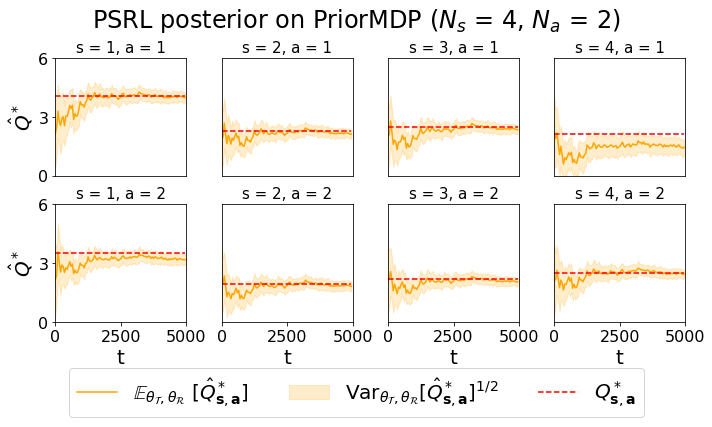

In [131]:
P, R = environment.get_mean_P_and_R()
pi, Q = solve_tabular_continuing_PI(P, R, gamma=0.9, max_iter=max_iter)

agent = load_agent(environment, PSRLAgent(agent_params), seed=0)

Qs = []
for t in np.arange(num_time_steps // save_every):
          
    Qs.append([])
    
    for i in range(100):
        agent.Ppost, agent.Rpost = agent.Ppost_log[t], agent.Rpost_log[t]
        P, R = agent.sample_posterior()
        pi, Q_ = solve_tabular_continuing_PI(P, R, gamma=0.9, max_iter=max_iter)
        Qs[-1].append(Q_)
            
Qs = np.array(Qs)
means = np.mean(Qs, axis=1)
stds = np.var(Qs, axis=1)**0.5

P, R = environment.get_mean_P_and_R()
pi, Q = solve_tabular_continuing_PI(P, R, gamma=0.9, max_iter=max_iter)

fig = plt.figure(figsize=(10, 6))

color = 'orange'
actions = ['left', 'right']
leg_names = ['$\mathbb{E}_{\\theta_{\mathcal{T}}, \\theta_{\mathcal{R}}}~[\hat{Q}^*_{\mathbf{s}, \mathbf{a}}]$',
             'Var$_{\\theta_{\mathcal{T}}, \\theta_{\mathcal{R}}}[\hat{Q}^*_{\mathbf{s}, \mathbf{a}}]^{1/2}$',
             '$Q^*_{\mathbf{s}, \mathbf{a}}$']
leg = [None] * 3

for s in range(Ns):
    for a in range(Na):
        
        plt.subplot(Na, Ns, s + Ns * a + 1)
        leg[0], = plt.plot(np.arange(len(means[:, s, a])) * save_every, means[:, s, a], color=color)
        leg[1] = plt.fill_between(np.arange(len(means[:, s, a])) * save_every, 
                                   means[:, s, a] + stds[:, s, a],
                                   means[:, s, a] - stds[:, s, a],
                                   color=color, alpha=0.2)
        
        leg[2], = plt.plot(np.arange(len(means[:, s, a])) * save_every,
                          np.ones(len(means[:, s, a])) * Q[s, a], 
                          '--',
                          color='red')
        plt.ylim([0, 6])
        plt.yticks([0, 3, 6])
        plt.xlim([0, len(means[:, s, a])])
        plt.xticks([0, num_time_steps // 2, num_time_steps])
        plt.tight_layout()
        
        if s > 0:
            plt.yticks([])
        else:
            plt.ylabel('$\hat{Q}^*$', fontsize=20)
        if a == 0:
            plt.xticks([])
        else:
            plt.xlabel('t', fontsize=20)
        
        plt.title(r's = {}, a = {}'.format(s + 1, a + 1), fontsize=15)
            
fig.suptitle('PSRL posterior on PriorMDP ($N_s$ = {}, $N_a$ = {})'.format(Ns, Na), fontsize=24)
plt.figlegend(leg, leg_names, loc = 'lower center', ncol=3, labelspacing=0., fontsize=20)
plt.tight_layout(w_pad=1)
fig.subplots_adjust(top=0.86, bottom=0.25)

mu0, lamda, alpha, beta = agent.mu0, agent.lamda, agent.alpha, agent.beta
save_name = 'psrl-{}-{}-{}-{}-posterior-priormdp-{}-{}'.format(mu0, lamda, alpha, beta, Ns, Na).replace('.', '_')
plt.savefig(fig_loc + save_name + '.pdf', bbox_inches='tight')
plt.show()

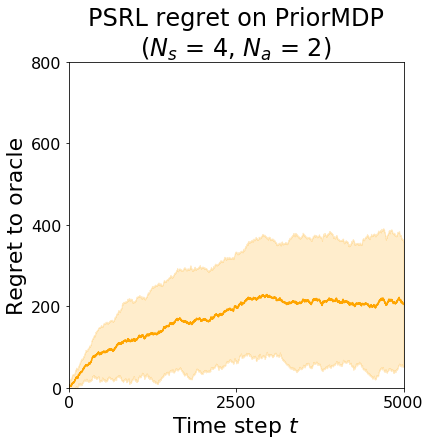

In [132]:
color = 'orange'

agent_rs, oracle_rs = [], []
for seed in range(10):
    
    # Define agent
    agent = PSRLAgent(agent_params)
    agent = load_agent(environment, agent, seed=seed)
    
    agent_rs.append(agent.train_r)

    oracle_r = run_oracle_experiment(environment=environment,
                                     seed=seed,
                                     gamma=0.9,
                                     num_time_steps=num_time_steps,
                                     num_PI_iter=max_iter)[2]
    
    oracle_rs.append(oracle_r)
    
agent_rs, oracle_rs = np.array(agent_rs), np.array(oracle_rs)

regrets = np.cumsum(oracle_rs - agent_rs, axis=-1)
means = np.mean(regrets, axis=0)
stds = np.var(regrets, axis=0)**0.5

plt.figure(figsize=(6, 6))
plt.plot(means, color=color)
plt.fill_between(np.arange(len(means)), means - stds, means + stds, color=color, alpha=0.2)
plt.locator_params(axis='y', nbins=4)
plt.locator_params(axis='x', nbins=4)
plt.title('PSRL regret on PriorMDP\n($N_s$ = {}, $N_a$ = {})'.format(Ns, Na), fontsize=24)
plt.xlabel('Time step $t$', fontsize=22)
plt.ylabel('Regret to oracle', fontsize=22)
plt.xlim([0, num_time_steps])
plt.xticks([0, num_time_steps // 2, num_time_steps])
plt.ylim([0, 800])

mu0, lamda, alpha, beta = agent.mu0, agent.lamda, agent.alpha, agent.beta
save_name = 'psrl-{}-{}-{}-{}-regret-priormdp-{}-{}'.format(mu0, lamda, alpha, beta, Ns, Na).replace('.', '_')
plt.savefig(fig_loc + save_name + '.pdf', bbox_inches='tight')
plt.show()

# UBE

In [133]:
# Agent parameters
agent_params = {'gamma'            : 0.9,
                'kappa'            : 1.0,
                'mu0'              : 0.0,
                'lamda'            : 4.0,
                'alpha'            : 3.0,
                'beta'             : 3.0,
                'Rmax'             : environment.get_mean_P_and_R()[1].max(),
                'max_iter'         : max_iter,
                'zeta'             : 1.0,
                'num_dyn_samples'  : 100,
                'sa_list'          : environment.sa_list()}

In [135]:
for seed in tqdm(range(10)):
    
    # Define agent
    agent = UbeNoUnrollAgent(agent_params)

    # Run experiment
    run_experiment(environment=environment,
                   agent=agent,
                   seed=seed,
                   num_time_steps=num_time_steps,
                   max_buffer_length=max_buffer_length,
                   save_every=save_every)

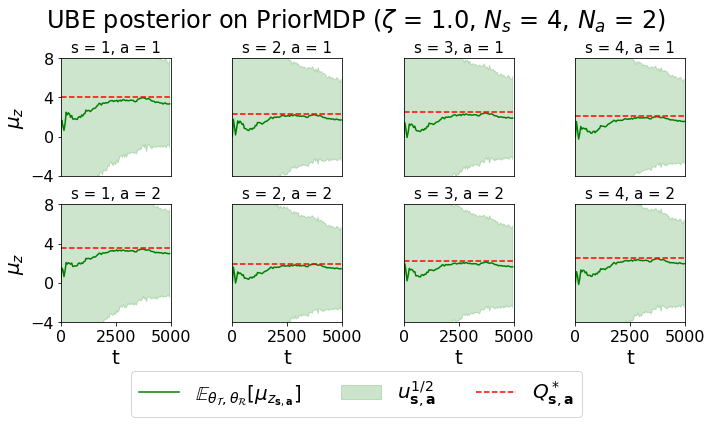

In [136]:
P, R = environment.get_mean_P_and_R()
pi, Q = solve_tabular_continuing_PI(P, R, gamma=0.9, max_iter=max_iter)

agent = load_agent(environment, UbeNoUnrollAgent(agent_params), seed=0)

means, stds = [], []
for t in np.arange(num_time_steps // save_every):
                
    means.append(agent.Qmu_log[t])
    stds.append(agent.Qvar_log[t]**0.5)
            
means = np.array(means)
stds = np.array(stds)

fig = plt.figure(figsize=(10, 6))

color = 'green'
actions = ['left', 'right']
leg_names = ['$\mathbb{E}_{\\theta_{\mathcal{T}}, \\theta_{\mathcal{R}}}[\mu_{z_{\mathbf{s}, \mathbf{a}}}]$',
             '$u^{1/2}_{\mathbf{s}, \mathbf{a}}$',
             '$Q^*_{\mathbf{s}, \mathbf{a}}$']
leg = [None] * 3

s, a = 0, 0

for s in range(Ns):
    for a in range(Na):
        
        plt.subplot(Na, Ns, s + Ns * a + 1)
        leg[0], = plt.plot(np.arange(len(means[:, s, a])) * save_every, means[:, s, a], color=color)
        leg[1] = plt.fill_between(np.arange(len(means[:, s, a])) * save_every, 
                                   means[:, s, a] + stds[:, s, a],
                                   means[:, s, a] - stds[:, s, a],
                                   color=color, alpha=0.2)
        
        leg[2], = plt.plot(np.arange(len(means[:, s, a])) * save_every,
                          np.ones(len(means[:, s, a])) * Q[s, a], 
                          '--',
                          color='red')
        
        plt.ylim([-4, 8])
        plt.yticks([-4, 0, 4, 8])
        plt.xlim([0, len(means[:, s, a])])
        plt.xticks([0, num_time_steps // 2, num_time_steps])
        plt.tight_layout()
        
        if s > 0:
            plt.yticks([])
        else:
            plt.ylabel('$\mu_z$', fontsize=20)
        if a == 0:
            plt.xticks([])
        else:
            plt.xlabel('t', fontsize=20)
        
        plt.title(r's = {}, a = {}'.format(s + 1, a + 1), fontsize=15)
            
fig.suptitle('UBE posterior on PriorMDP ($\zeta$ = {}, $N_s$ = {}, $N_a$ = {})'.format(agent.zeta, Ns, Na),
             fontsize=24)
plt.figlegend(leg, leg_names, loc = 'lower center', ncol=3, labelspacing=0., fontsize=20)
fig.subplots_adjust(top=0.86, bottom=0.25)

mu0, lamda, alpha, beta, zeta = agent.mu0, agent.lamda, agent.alpha, agent.beta, agent.zeta
save_name = 'ube-{}-{}-{}-{}-{}-posterior-priormdp-{}-{}'.format(mu0, lamda, alpha, beta, zeta, Ns, Na)
save_name = save_name.replace('.', '_')
plt.savefig(fig_loc + save_name + '.pdf', bbox_inches='tight')
plt.show()

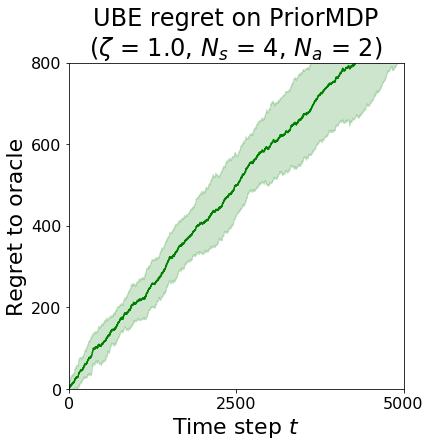

In [137]:
color = 'green'

agent_rs, oracle_rs = [], []
for seed in range(10):
    
    # Define agent
    agent = load_agent(environment, UbeNoUnrollAgent(agent_params), seed=seed)
    
    agent_rs.append(agent.train_r)

    oracle_r = run_oracle_experiment(environment=environment,
                                     seed=seed,
                                     gamma=0.9,
                                     num_time_steps=num_time_steps,
                                     num_PI_iter=max_iter)[2]
    
    oracle_rs.append(oracle_r)
    
agent_rs, oracle_rs = np.array(agent_rs), np.array(oracle_rs)

regrets = np.cumsum(oracle_rs - agent_rs, axis=-1)
means = np.mean(regrets, axis=0)
stds = np.var(regrets, axis=0)**0.5

plt.figure(figsize=(6, 6))
plt.plot(means, color=color)
plt.fill_between(np.arange(len(means)), means - stds, means + stds, color=color, alpha=0.2)
plt.locator_params(axis='y', nbins=4)
plt.locator_params(axis='x', nbins=4)
plt.title('UBE regret on PriorMDP\n($\zeta$ = {}, $N_s$ = {}, $N_a$ = {})'.format(agent.zeta, Ns, Na),
          fontsize=24)
plt.xlabel('Time step $t$', fontsize=22)
plt.ylabel('Regret to oracle', fontsize=22)
plt.xlim([0, num_time_steps])
plt.xticks([0, num_time_steps // 2, num_time_steps])
plt.ylim([0, 800])

mu0, lamda, alpha, beta, zeta = agent.mu0, agent.lamda, agent.alpha, agent.beta, agent.zeta
save_name = 'ube-{}-{}-{}-{}-{}-regret-priormdp-{}-{}'.format(mu0, lamda, alpha, beta, zeta, Ns, Na)
save_name = save_name.replace('.', '_')
plt.savefig(fig_loc + save_name + '.pdf', bbox_inches='tight')
plt.show()

# UBE

In [146]:
# Agent parameters
agent_params = {'gamma'            : 0.9,
                'kappa'            : 1.0,
                'mu0'              : 0.0,
                'lamda'            : 4.0,
                'alpha'            : 3.0,
                'beta'             : 3.0,
                'Rmax'             : environment.get_mean_P_and_R()[1].max(),
                'max_iter'         : max_iter,
                'zeta'             : 0.1,
                'num_dyn_samples'  : 100,
                'sa_list'          : environment.sa_list()}

In [147]:
for seed in tqdm(range(10)):

    # Define agent
    agent = UbeNoUnrollAgent(agent_params)

    # Run experiment
    run_experiment(environment=environment,
                   agent=agent,
                   seed=seed,
                   num_time_steps=num_time_steps,
                   max_buffer_length=max_buffer_length,
                   save_every=save_every)

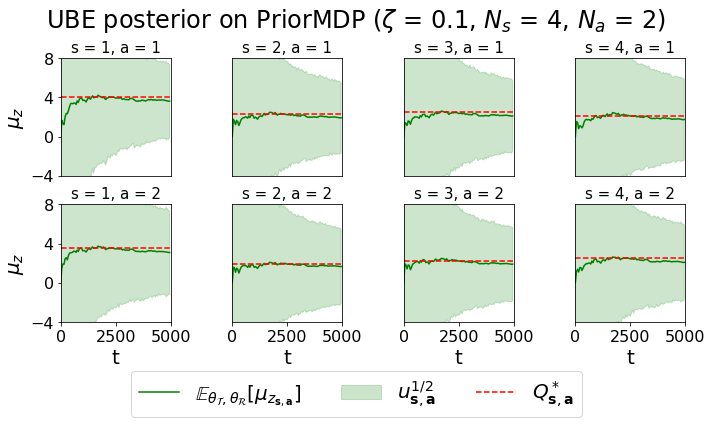

In [148]:
P, R = environment.get_mean_P_and_R()
pi, Q = solve_tabular_continuing_PI(P, R, gamma=0.9, max_iter=max_iter)

agent = load_agent(environment, UbeNoUnrollAgent(agent_params), seed=0)

means, stds = [], []
for t in np.arange(num_time_steps // save_every):
                
    means.append(agent.Qmu_log[t])
    stds.append(agent.Qvar_log[t]**0.5)
            
means = np.array(means)
stds = np.array(stds)

fig = plt.figure(figsize=(10, 6))

color = 'green'
actions = ['left', 'right']
leg_names = ['$\mathbb{E}_{\\theta_{\mathcal{T}}, \\theta_{\mathcal{R}}}[\mu_{z_{\mathbf{s}, \mathbf{a}}}]$',
             '$u^{1/2}_{\mathbf{s}, \mathbf{a}}$',
             '$Q^*_{\mathbf{s}, \mathbf{a}}$']
leg = [None] * 3

s, a = 0, 0

for s in range(Ns):
    for a in range(Na):
        
        plt.subplot(Na, Ns, s + Ns * a + 1)
        leg[0], = plt.plot(np.arange(len(means[:, s, a])) * save_every, means[:, s, a], color=color)
        leg[1] = plt.fill_between(np.arange(len(means[:, s, a])) * save_every, 
                                   means[:, s, a] + stds[:, s, a],
                                   means[:, s, a] - stds[:, s, a],
                                   color=color, alpha=0.2)
        
        leg[2], = plt.plot(np.arange(len(means[:, s, a])) * save_every,
                          np.ones(len(means[:, s, a])) * Q[s, a], 
                          '--',
                          color='red')
        
        plt.ylim([-4, 8])
        plt.yticks([-4, 0, 4, 8])
        plt.xlim([0, len(means[:, s, a])])
        plt.xticks([0, num_time_steps // 2, num_time_steps])
        plt.tight_layout()
        
        if s > 0:
            plt.yticks([])
        else:
            plt.ylabel('$\mu_z$', fontsize=20)
        if a == 0:
            plt.xticks([])
        else:
            plt.xlabel('t', fontsize=20)
        
        plt.title(r's = {}, a = {}'.format(s + 1, a + 1), fontsize=15)
            
fig.suptitle('UBE posterior on PriorMDP ($\zeta$ = {}, $N_s$ = {}, $N_a$ = {})'.format(agent.zeta, Ns, Na),
             fontsize=24)
plt.figlegend(leg, leg_names, loc = 'lower center', ncol=3, labelspacing=0., fontsize=20)
fig.subplots_adjust(top=0.86, bottom=0.25)

mu0, lamda, alpha, beta, zeta = agent.mu0, agent.lamda, agent.alpha, agent.beta, agent.zeta
save_name = 'ube-{}-{}-{}-{}-{}-posterior-priormdp-{}-{}'.format(mu0, lamda, alpha, beta, zeta, Ns, Na)
save_name = save_name.replace('.', '_')
plt.savefig(fig_loc + save_name + '.pdf', bbox_inches='tight')
plt.show()

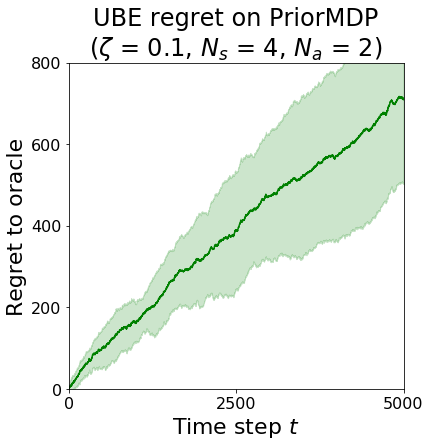

In [149]:
color = 'green'

agent_rs, oracle_rs = [], []
for seed in range(10):
    
    # Define agent
    agent = load_agent(environment, UbeNoUnrollAgent(agent_params), seed=seed)
    
    agent_rs.append(agent.train_r)

    oracle_r = run_oracle_experiment(environment=environment,
                                     seed=seed,
                                     gamma=0.9,
                                     num_time_steps=num_time_steps,
                                     num_PI_iter=max_iter)[2]
    
    oracle_rs.append(oracle_r)
    
agent_rs, oracle_rs = np.array(agent_rs), np.array(oracle_rs)

regrets = np.cumsum(oracle_rs - agent_rs, axis=-1)
means = np.mean(regrets, axis=0)
stds = np.var(regrets, axis=0)**0.5

plt.figure(figsize=(6, 6))
plt.plot(means, color=color)
plt.fill_between(np.arange(len(means)), means - stds, means + stds, color=color, alpha=0.2)
plt.locator_params(axis='y', nbins=4)
plt.locator_params(axis='x', nbins=4)
plt.title('UBE regret on PriorMDP\n($\zeta$ = {}, $N_s$ = {}, $N_a$ = {})'.format(agent.zeta, Ns, Na), fontsize=24)
plt.xlabel('Time step $t$', fontsize=22)
plt.ylabel('Regret to oracle', fontsize=22)
plt.xlim([0, num_time_steps])
plt.xticks([0, num_time_steps // 2, num_time_steps])
plt.ylim([0, 800])

mu0, lamda, alpha, beta, zeta = agent.mu0, agent.lamda, agent.alpha, agent.beta, agent.zeta
save_name = 'ube-{}-{}-{}-{}-{}-regret-priormdp-{}-{}'.format(mu0, lamda, alpha, beta, zeta, Ns, Na)
save_name = save_name.replace('.', '_')
plt.savefig(fig_loc + save_name + '.pdf', bbox_inches='tight')
plt.show()

# Moment Matching

In [142]:
# Agent constants
agent_params = {'gamma'            : 0.9,
                'kappa'            : 1.0,
                'mu0'              : 0.0,
                'lamda'            : 4.0,
                'alpha'            : 3.0,
                'beta'             : 3.0,
                'max_iter'         : max_iter,
                'zeta'             : 1.0,
                'num_dyn_samples'  : 100, 
                'sa_list'          : environment.sa_list()}

In [143]:
for seed in tqdm(range(10)):

    # Define agent
    agent = MomentMatchingAgent(agent_params)

    # Run experiment
    run_experiment(environment=environment,
                   agent=agent,
                   seed=seed,
                   num_time_steps=num_time_steps,
                   max_buffer_length=max_buffer_length,
                   save_every=save_every)

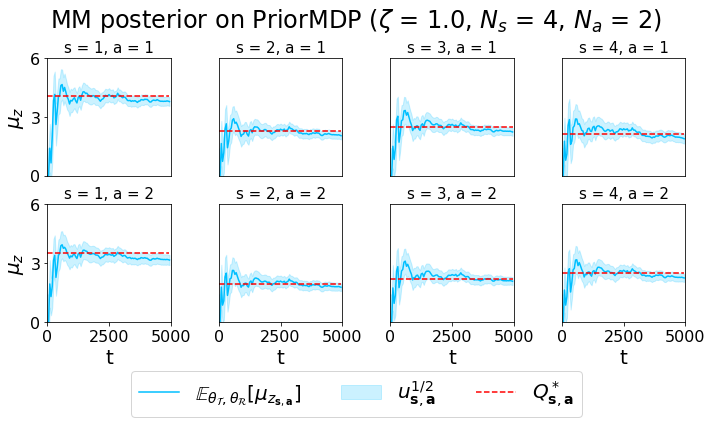

In [144]:
P, R = environment.get_mean_P_and_R()
pi, Q = solve_tabular_continuing_PI(P, R, gamma=0.9, max_iter=max_iter)

agent = load_agent(environment, MomentMatchingAgent(agent_params), seed=0)

means, stds = [], []
for t in np.arange(num_time_steps // save_every):
    
    means.append(agent.mu_log[t])
    stds.append(agent.var_log[t]**0.5)
            
means = np.array(means)
stds = np.array(stds)

fig = plt.figure(figsize=(10, 6))

color = 'deepskyblue'
actions = ['left', 'right']
leg_names = ['$\mathbb{E}_{\\theta_{\mathcal{T}}, \\theta_{\mathcal{R}}}[\mu_{z_{\mathbf{s}, \mathbf{a}}}]$',
             '$u^{1/2}_{\mathbf{s}, \mathbf{a}}$',
             '$Q^*_{\mathbf{s}, \mathbf{a}}$']
leg = [None] * 3

s, a = 0, 0

for s in range(Ns):
    for a in range(Na):
        
        plt.subplot(Na, Ns, s + Ns * a + 1)
        leg[0], = plt.plot(np.arange(len(means[:, s, a])) * save_every, means[:, s, a], color=color)
        leg[1] = plt.fill_between(np.arange(len(means[:, s, a])) * save_every, 
                                   means[:, s, a] + stds[:, s, a],
                                   means[:, s, a] - stds[:, s, a],
                                   color=color, alpha=0.2)
        
        leg[2], = plt.plot(np.arange(len(means[:, s, a])) * save_every,
                          np.ones(len(means[:, s, a])) * Q[s, a], 
                          '--',
                          color='red')
        
        plt.ylim([0, 6])
        plt.yticks([0, 3, 6])
        plt.xlim([0, len(means[:, s, a])])
        plt.xticks([0, num_time_steps // 2, num_time_steps])
        plt.tight_layout()
        
        if s > 0:
            plt.yticks([])
        else:
            plt.ylabel('$\mu_z$', fontsize=20)
        if a == 0:
            plt.xticks([])
        else:
            plt.xlabel('t', fontsize=20)
        
        plt.title(r's = {}, a = {}'.format(s + 1, a + 1), fontsize=15)
            
fig.suptitle('MM posterior on PriorMDP ($\zeta$ = {}, $N_s$ = {}, $N_a$ = {})'.format(agent.zeta, Ns, Na),
             fontsize=24)
plt.figlegend(leg, leg_names, loc = 'lower center', ncol=3, labelspacing=0., fontsize=20)
fig.subplots_adjust(top=0.86, bottom=0.25)

mu0, lamda, alpha, beta, zeta = agent.mu0, agent.lamda, agent.alpha, agent.beta, agent.zeta
save_name = 'mm-{}-{}-{}-{}-{}-posterior-priormdp-{}-{}'.format(mu0, lamda, alpha, beta, zeta, Ns, Na)
save_name = save_name.replace('.', '_')
plt.savefig(fig_loc + save_name + '.pdf', bbox_inches='tight')
plt.show()

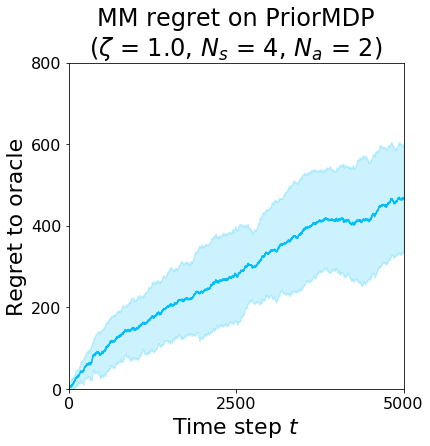

In [145]:
color = 'deepskyblue'

agent_rs, oracle_rs = [], []
for seed in range(10):
    
    # Define agent
    agent = load_agent(environment, MomentMatchingAgent(agent_params), seed=seed)
    
    agent_rs.append(agent.train_r)

    oracle_r = run_oracle_experiment(environment=environment,
                                     seed=seed,
                                     gamma=0.9,
                                     num_time_steps=num_time_steps,
                                     num_PI_iter=max_iter)[2]
    
    oracle_rs.append(oracle_r)
    
agent_rs, oracle_rs = np.array(agent_rs), np.array(oracle_rs)

regrets = np.cumsum(oracle_rs - agent_rs, axis=-1)
means = np.mean(regrets, axis=0)
stds = np.var(regrets, axis=0)**0.5
plt.figure(figsize=(6, 6))
plt.plot(means, color=color)
plt.fill_between(np.arange(len(means)), means - stds, means + stds, color=color, alpha=0.2)
plt.locator_params(axis='y', nbins=4)
plt.locator_params(axis='x', nbins=4)
plt.title('MM regret on PriorMDP\n($\zeta$ = {}, $N_s$ = {}, $N_a$ = {})'.format(agent.zeta, Ns, Na),
          fontsize=24)
plt.xlabel('Time step $t$', fontsize=22)
plt.ylabel('Regret to oracle', fontsize=22)
plt.xlim([0, num_time_steps])
plt.xticks([0, num_time_steps // 2, num_time_steps])
plt.ylim([0, 800])

mu0, lamda, alpha, beta, zeta = agent.mu0, agent.lamda, agent.alpha, agent.beta, agent.zeta
save_name = 'mm-{}-{}-{}-{}-{}-regret-priormdp-{}-{}'.format(mu0, lamda, alpha, beta, zeta, Ns, Na)
save_name = save_name.replace('.', '_')
plt.savefig(fig_loc + save_name + '.pdf', bbox_inches='tight')
plt.show()